# F1 Prize Picks Optimizer

This notebook implements the Prize Picks optimization engine with:
- Kelly Criterion for optimal bet sizing
- Correlation management for multi-bet optimization
- Expected Value (EV) calculations
- Risk management and portfolio optimization
- Parlay and multi-leg bet optimization

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
# plt.style.use('seaborn-darkgrid') # Original style - may not work on all systems
# Safe plotting style setup
try:
    import seaborn as sns
    sns.set_theme()  # Modern seaborn initialization
except:
    try:
        plt.style.use('ggplot')  # Fallback style
    except:
        pass  # Use default style
sns.set_palette('husl')

In [ ]:
# Setup imports with robust path handling
import sys
import os
from pathlib import Path

# Determine the notebook location and add necessary paths
try:
    # In Jupyter notebooks, __file__ might not be defined
    notebook_dir = Path.cwd()
    
    # Check if we're in the advanced directory
    if 'advanced' in str(notebook_dir):
        # We're in the advanced directory
        if str(notebook_dir) not in sys.path:
            sys.path.insert(0, str(notebook_dir))
    else:
        # Add the advanced directory to path
        workspace_root = notebook_dir
        
        # Navigate to find the advanced directory
        possible_paths = [
            notebook_dir / 'notebooks' / 'advanced',  # From workspace root
            notebook_dir / 'advanced',  # From notebooks directory
            notebook_dir.parent / 'advanced',  # If we're in a sibling directory
            notebook_dir.parent / 'notebooks' / 'advanced',  # From other locations
        ]
        
        for path in possible_paths:
            if path.exists() and str(path) not in sys.path:
                sys.path.insert(0, str(path))
                break
                
except Exception as e:
    print(f"Path setup warning: {e}")
    # Fallback to simple path addition
    sys.path.append('.')

# Import F1DB data loader
from f1db_data_loader import load_f1db_data

# Import optimization components from f1_ml package
from f1_ml.optimization import PrizePicksOptimizer, PrizePicksBetTypes, KellyCriterion, CorrelationManager

## 1. Prize Picks Bet Types and Structures

In [ ]:
# Display Prize Picks structure using imported class
print("Prize Picks Payout Structure:")
print("=" * 40)
for picks, multiplier in PrizePicksBetTypes.PAYOUTS.items():
    breakeven = PrizePicksBetTypes.required_win_rate(picks)
    print(f"{picks} picks: {multiplier}x payout (breakeven: {breakeven:.1%})")

# Visualize payout structure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

picks = list(PrizePicksBetTypes.PAYOUTS.keys())
payouts = list(PrizePicksBetTypes.PAYOUTS.values())
breakeven_rates = [PrizePicksBetTypes.required_win_rate(p) for p in picks]

ax1.bar(picks, payouts, color='green', alpha=0.7)
ax1.set_xlabel('Number of Picks')
ax1.set_ylabel('Payout Multiplier')
ax1.set_title('Prize Picks Payout Structure')
ax1.grid(True, alpha=0.3)

ax2.plot(picks, breakeven_rates, 'o-', color='red', markersize=10)
ax2.axhline(y=0.5, color='gray', linestyle='--', label='50% win rate')
ax2.set_xlabel('Number of Picks')
ax2.set_ylabel('Required Win Rate')
ax2.set_title('Breakeven Win Rate by Picks')
ax2.set_ylim(0, 0.6)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## 2. Kelly Criterion Implementation

In [ ]:
# Demonstrate Kelly Criterion using imported class
kelly = KellyCriterion(kelly_fraction=0.25)

# Example calculations
probabilities = np.linspace(0.3, 0.8, 50)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Kelly stake vs probability for different pick counts
ax = axes[0, 0]
for n_picks in [2, 3, 4, 5]:
    odds = PrizePicksBetTypes.PAYOUTS[n_picks]
    stakes = [kelly.calculate_kelly_stake(p, odds) for p in probabilities]
    ax.plot(probabilities, stakes, label=f'{n_picks} picks ({odds}x)')

ax.set_xlabel('Win Probability')
ax.set_ylabel('Kelly Stake (fraction of bankroll)')
ax.set_title('Optimal Stake Size by Probability')
ax.legend()
ax.grid(True, alpha=0.3)

# Expected value
ax = axes[0, 1]
for n_picks in [2, 3, 4, 5]:
    odds = PrizePicksBetTypes.PAYOUTS[n_picks]
    evs = [kelly.expected_value(p, odds) for p in probabilities]
    ax.plot(probabilities, evs, label=f'{n_picks} picks')

ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Win Probability')
ax.set_ylabel('Expected Value (per $1 bet)')
ax.set_title('Expected Value by Win Probability')
ax.legend()
ax.grid(True, alpha=0.3)

# Multi-pick Kelly with correlation
ax = axes[1, 0]
base_probs = [0.6, 0.65, 0.7, 0.75]
correlations = np.linspace(0, 0.8, 20)

for n_picks in [2, 3, 4]:
    kelly_stakes = []
    for corr in correlations:
        # Adjust probabilities for correlation
        adjusted_probs = base_probs[:n_picks]
        # Simple correlation adjustment (in reality, more complex)
        combined_prob = np.prod(adjusted_probs) * (1 - corr * 0.3)
        stake = kelly.calculate_kelly_stake(combined_prob, PrizePicksBetTypes.PAYOUTS[n_picks])
        kelly_stakes.append(stake)
    
    ax.plot(correlations, kelly_stakes, label=f'{n_picks} picks')

ax.set_xlabel('Correlation Between Picks')
ax.set_ylabel('Optimal Kelly Stake')
ax.set_title('Impact of Correlation on Optimal Stake')
ax.legend()
ax.grid(True, alpha=0.3)

# Growth rate visualization
ax = axes[1, 1]
probability = 0.65
stake_fractions = np.linspace(0, 0.5, 100)

for n_picks in [2, 3, 4]:
    odds = PrizePicksBetTypes.PAYOUTS[n_picks]
    growth_rates = [kelly.calculate_growth_rate(probability, odds, f) for f in stake_fractions]
    optimal_stake = kelly.calculate_kelly_stake(probability, odds)
    
    ax.plot(stake_fractions, growth_rates, label=f'{n_picks} picks')
    ax.axvline(x=optimal_stake, color='red', linestyle='--', alpha=0.3)

ax.set_xlabel('Stake Fraction')
ax.set_ylabel('Expected Growth Rate')
ax.set_title(f'Growth Rate vs Stake Size (p={probability})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Correlation Analysis and Management

In [ ]:
# Initialize correlation manager using imported class
corr_manager = CorrelationManager()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_manager.correlation_matrix, 
            annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1)
plt.title('Bet Type Correlation Matrix')
plt.tight_layout()
plt.show()

# Example correlation calculations
print("\nExample Parlay Correlations:")
print("=" * 50)

examples = [
    (['top_10', 'top_5'], ['Hamilton', 'Hamilton']),
    (['top_10', 'dnf'], ['Verstappen', 'Verstappen']),
    (['top_3', 'beat_teammate'], ['Leclerc', 'Sainz']),
    (['points', 'points', 'points'], ['Hamilton', 'Verstappen', 'Leclerc'])
]

for bet_types, drivers in examples:
    corr = corr_manager.calculate_parlay_correlation(bet_types, drivers)
    print(f"Bets: {bet_types}")
    print(f"Drivers: {drivers}")
    print(f"Correlation: {corr:.3f}\n")

## 4. Prize Picks Optimization Engine

In [ ]:
# Import PrizePicksOptimizer from the f1_ml package
from f1_ml.optimization import PrizePicksOptimizer

# Initialize optimizer
optimizer = PrizePicksOptimizer(kelly_fraction=0.25, max_correlation=0.6)

# Note: Real predictions will be generated in the "Real Race Application" section below
print("Prize Picks Optimizer initialized. Predictions will be generated using real F1 data.")

## 5. Risk Management and Bankroll Optimization


Risk Analysis:
total_exposure: 0.00
exposure_pct: 0.0%
var_95: $0.00
var_99: $0.00
max_loss: $0.00
expected_return: $0.00
n_bets: 0.00
sharpe_ratio: 0.00


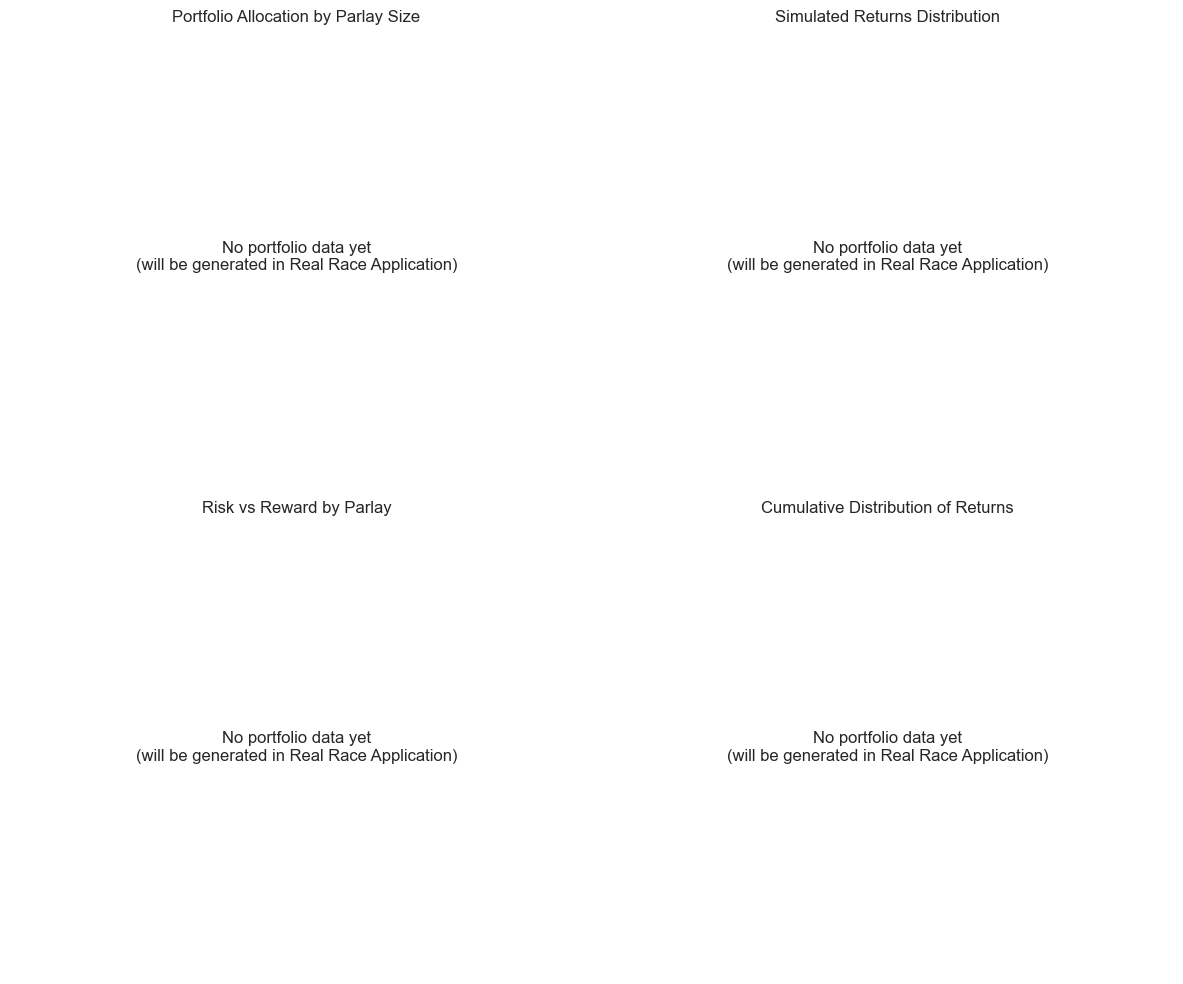

In [7]:
class RiskManager:
    """
    Risk management for Prize Picks betting
    """
    def __init__(self, max_exposure=0.25, max_single_bet=0.10):
        self.max_exposure = max_exposure  # Max % of bankroll at risk
        self.max_single_bet = max_single_bet  # Max % on single parlay
    
    def calculate_var(self, portfolio, confidence_level=0.95):
        """
        Calculate Value at Risk for portfolio
        """
        if not portfolio:
            return 0
        
        # Simulate outcomes
        n_simulations = 10000
        outcomes = []
        
        for _ in range(n_simulations):
            total_return = 0
            
            for parlay in portfolio:
                # Simulate win/loss
                if np.random.random() < parlay['adjusted_prob']:
                    # Win
                    total_return += parlay['bet_size'] * (parlay['payout'] - 1)
                else:
                    # Loss
                    total_return -= parlay['bet_size']
            
            outcomes.append(total_return)
        
        # Calculate VaR
        outcomes = np.array(outcomes)
        var = np.percentile(outcomes, (1 - confidence_level) * 100)
        
        return var
    
    def calculate_risk_metrics(self, portfolio, bankroll):
        """
        Calculate comprehensive risk metrics
        """
        total_exposure = sum(p['bet_size'] for p in portfolio)
        
        metrics = {
            'total_exposure': total_exposure,
            'exposure_pct': total_exposure / bankroll,
            'var_95': self.calculate_var(portfolio, 0.95),
            'var_99': self.calculate_var(portfolio, 0.99),
            'max_loss': -total_exposure,
            'expected_return': sum(p['expected_value'] * p['bet_size'] for p in portfolio),
            'n_bets': len(portfolio)
        }
        
        # Sharpe ratio approximation
        if metrics['total_exposure'] > 0:
            returns = [p['expected_value'] * p['bet_size'] / metrics['total_exposure'] 
                      for p in portfolio]
            metrics['sharpe_ratio'] = np.mean(returns) / (np.std(returns) + 1e-6)
        else:
            metrics['sharpe_ratio'] = 0
        
        return metrics
    
    def apply_risk_limits(self, portfolio, bankroll):
        """
        Apply risk limits to portfolio
        """
        # Check total exposure
        total_exposure = sum(p['bet_size'] for p in portfolio)
        
        if total_exposure > self.max_exposure * bankroll:
            # Scale down all bets proportionally
            scale_factor = (self.max_exposure * bankroll) / total_exposure
            for p in portfolio:
                p['bet_size'] *= scale_factor
                p['allocation'] *= scale_factor
        
        # Check individual bet limits
        for p in portfolio:
            if p['bet_size'] > self.max_single_bet * bankroll:
                p['bet_size'] = self.max_single_bet * bankroll
                p['allocation'] = p['bet_size'] / bankroll
        
        return portfolio

# Initialize risk manager
risk_manager = RiskManager(max_exposure=0.25, max_single_bet=0.10)

# NOTE: Portfolio will be created in the Real Race Application section below
# For now, just initialize an empty portfolio for demonstration
portfolio = []

# Apply risk limits to portfolio
portfolio = risk_manager.apply_risk_limits(portfolio, bankroll=100)

# Calculate risk metrics
risk_metrics = risk_manager.calculate_risk_metrics(portfolio, bankroll=100)

print("\nRisk Analysis:")
print("=" * 50)
for metric, value in risk_metrics.items():
    if 'pct' in metric:
        print(f"{metric}: {value:.1%}")
    elif metric in ['var_95', 'var_99', 'max_loss', 'expected_return']:
        print(f"{metric}: ${value:.2f}")
    else:
        print(f"{metric}: {value:.2f}")

# Visualize risk profile
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Portfolio composition
ax = axes[0, 0]
if portfolio:
    bet_sizes = [p['bet_size'] for p in portfolio]
    labels = [f"{p['n_picks']}-pick" for p in portfolio]
    ax.pie(bet_sizes, labels=labels, autopct='%1.1f%%')
    ax.set_title('Portfolio Allocation by Parlay Size')
else:
    ax.text(0.5, 0.5, 'No portfolio data yet\n(will be generated in Real Race Application)', 
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Portfolio Allocation by Parlay Size')
    ax.axis('off')

# Expected returns distribution
ax = axes[0, 1]
if portfolio:
    n_simulations = 1000
    simulation_returns = []

    for _ in range(n_simulations):
        total = 0
        for p in portfolio:
            if np.random.random() < p['adjusted_prob']:
                total += p['bet_size'] * (p['payout'] - 1)
            else:
                total -= p['bet_size']
        simulation_returns.append(total)

    ax.hist(simulation_returns, bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='red', linestyle='--', label='Breakeven')
    ax.axvline(x=risk_metrics['expected_return'], color='green', 
              linestyle='--', label='Expected Return')
    ax.set_xlabel('Return ($)')
    ax.set_ylabel('Frequency')
    ax.set_title('Simulated Returns Distribution')
    ax.legend()
else:
    ax.text(0.5, 0.5, 'No portfolio data yet\n(will be generated in Real Race Application)', 
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Simulated Returns Distribution')
    ax.axis('off')

# Risk vs Reward
ax = axes[1, 0]
if portfolio:
    for p in portfolio:
        risk = 1 - p['adjusted_prob']
        reward = p['expected_value']
        size = p['bet_size'] * 10
        ax.scatter(risk, reward, s=size, alpha=0.6, 
                  label=f"{p['n_picks']}-pick")

    ax.set_xlabel('Risk (Loss Probability)')
    ax.set_ylabel('Expected Value per $1')
    ax.set_title('Risk vs Reward by Parlay')
    ax.legend()
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'No portfolio data yet\n(will be generated in Real Race Application)', 
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Risk vs Reward by Parlay')
    ax.axis('off')

# Cumulative probability of profit
ax = axes[1, 1]
if portfolio:
    sorted_returns = np.sort(simulation_returns)
    cumulative_prob = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)
    ax.plot(sorted_returns, cumulative_prob)
    ax.axvline(x=0, color='red', linestyle='--', label='Breakeven')
    ax.set_xlabel('Return ($)')
    ax.set_ylabel('Cumulative Probability')
    ax.set_title('Cumulative Distribution of Returns')
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Add profit probability
    profit_prob = (np.array(simulation_returns) > 0).mean()
    ax.text(0.05, 0.95, f'P(Profit) = {profit_prob:.1%}', 
            transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='wheat'))
else:
    ax.text(0.5, 0.5, 'No portfolio data yet\n(will be generated in Real Race Application)', 
            ha='center', va='center', transform=ax.transAxes, fontsize=12)
    ax.set_title('Cumulative Distribution of Returns')
    ax.axis('off')

plt.tight_layout()
plt.show()

## 6. Real Race Application

In [8]:
# F1 Real Data Predictions Generator
class F1PredictionsGenerator:
    """Generate race predictions using real F1 data"""
    
    def __init__(self, data_dir=None):
        """Initialize with F1 data"""
        # Determine the correct path based on where we're running from
        if data_dir is None:
            # Try to find the data directory
            possible_paths = [
                Path('../../data/f1db'),  # From notebooks/advanced
                Path('../data/f1db'),     # From notebooks
                Path('data/f1db'),        # From workspace root
                Path('./data/f1db'),      # Current directory
            ]
            
            for path in possible_paths:
                if path.exists():
                    data_dir = str(path)
                    break
            else:
                raise ValueError("Could not find F1 data directory. Please specify data_dir parameter.")
        
        self.data_dir = Path(data_dir)
        self.f1_data = None
        self.load_data()
        
    def load_data(self):
        """Load F1 data from CSV files"""
        # Load data using f1db_data_loader
        self.f1_data = load_f1db_data(data_dir=str(self.data_dir))
        
        # Ensure we have the key data
        if 'results' not in self.f1_data and 'races-race-results' in self.f1_data:
            self.f1_data['results'] = self.f1_data['races-race-results']
    
    def get_next_race(self, current_date=None):
        """Get the next upcoming race"""
        if current_date is None:
            current_date = datetime.now()
        elif isinstance(current_date, str):
            current_date = pd.to_datetime(current_date)
        
        races = self.f1_data.get('races', pd.DataFrame())
        if races.empty:
            return None
        
        # Convert date column to datetime
        races['date'] = pd.to_datetime(races['date'])
        
        # Find next race
        future_races = races[races['date'] > current_date]
        
        if future_races.empty:
            # If no future races, get the most recent race
            return races.sort_values('date').iloc[-1]
        
        return future_races.sort_values('date').iloc[0]
    
    def get_driver_stats(self, driver_id, season=None, last_n_races=10):
        """Calculate driver statistics from historical data"""
        results = self.f1_data.get('results', pd.DataFrame())
        
        if results.empty:
            return {}
        
        # Filter by driver
        driver_results = results[results['driverId'] == driver_id]
        
        if season and 'year' in driver_results.columns:
            driver_results = driver_results[driver_results['year'] == season]
        
        # Get recent results
        if 'year' in driver_results.columns and 'round' in driver_results.columns:
            recent_results = driver_results.sort_values(['year', 'round'], ascending=False).head(last_n_races)
        else:
            recent_results = driver_results.head(last_n_races)
        
        # Calculate statistics
        # Check which position column exists
        position_col = 'positionNumber' if 'positionNumber' in driver_results.columns else 'position'
        points_col = 'points'
        
        # Convert position to numeric
        if position_col in driver_results.columns:
            driver_results.loc[:, position_col] = pd.to_numeric(driver_results[position_col], errors='coerce')
            recent_results.loc[:, position_col] = pd.to_numeric(recent_results[position_col], errors='coerce')
        
        stats = {
            'races': len(driver_results),
            'wins': len(driver_results[driver_results[position_col] == 1]) if position_col in driver_results.columns else 0,
            'podiums': len(driver_results[driver_results[position_col] <= 3]) if position_col in driver_results.columns else 0,
            'top5': len(driver_results[driver_results[position_col] <= 5]) if position_col in driver_results.columns else 0,
            'top10': len(driver_results[driver_results[position_col] <= 10]) if position_col in driver_results.columns else 0,
            'points_finishes': len(driver_results[driver_results[points_col] > 0]) if points_col in driver_results.columns else 0,
            'dnf': len(driver_results[driver_results['reasonRetired'].notna()]) if 'reasonRetired' in driver_results.columns else 0,
            'avg_position': driver_results[driver_results[position_col] > 0][position_col].mean() if position_col in driver_results.columns else 20,
            'avg_points': driver_results[points_col].mean() if points_col in driver_results.columns else 0,
            'recent_avg_position': recent_results[recent_results[position_col] > 0][position_col].mean() if position_col in recent_results.columns else 20,
            'consistency': 1 / (1 + driver_results[driver_results[position_col] > 0][position_col].std()) if position_col in driver_results.columns else 0.5
        }
        
        # Calculate rates
        if stats['races'] > 0:
            stats['win_rate'] = stats['wins'] / stats['races']
            stats['podium_rate'] = stats['podiums'] / stats['races']
            stats['top5_rate'] = stats['top5'] / stats['races']
            stats['top10_rate'] = stats['top10'] / stats['races']
            stats['points_rate'] = stats['points_finishes'] / stats['races']
            stats['dnf_rate'] = stats['dnf'] / stats['races']
        else:
            stats.update({k + '_rate': 0 for k in ['win', 'podium', 'top5', 'top10', 'points', 'dnf']})
        
        return stats
    
    def generate_race_predictions_for_optimizer(self, race_name=None, season=None):
        """
        Generate realistic predictions for a specific race using real F1 data
        """
        # Get next race if not specified
        if race_name is None:
            next_race = self.get_next_race()
            if next_race is not None:
                race_name = next_race.get('officialName', 'Next Race')
                print(f"Generating predictions for: {race_name}")
                print(f"Date: {next_race.get('date', 'Unknown')}")
        
        # Get current season
        if season is None:
            season = datetime.now().year
        
        # Get all drivers
        drivers_df = self.f1_data.get('drivers', pd.DataFrame())
        results = self.f1_data.get('results', pd.DataFrame())
        
        # Get active drivers (those who raced in recent seasons)
        recent_years = [season, season - 1]
        
        # Handle different data structures
        if 'year' in results.columns:
            # Results already have year column
            active_driver_ids = results[results['year'].isin(recent_years)]['driverId'].unique()
        else:
            # Fallback: just get drivers from recent results
            active_driver_ids = results['driverId'].unique()[-40:]  # Last 40 unique drivers
        
        active_drivers = drivers_df[drivers_df['id'].isin(active_driver_ids)]
        
        predictions = []
        
        # Define current teammate pairs (2024/2025 season)
        teammate_pairs = {
            'max-verstappen': 'sergio-perez',
            'sergio-perez': 'max-verstappen',
            'lewis-hamilton': 'george-russell',
            'george-russell': 'lewis-hamilton',
            'charles-leclerc': 'carlos-sainz',
            'carlos-sainz': 'charles-leclerc',
            'lando-norris': 'oscar-piastri',
            'oscar-piastri': 'lando-norris',
            'fernando-alonso': 'lance-stroll',
            'lance-stroll': 'fernando-alonso',
            'esteban-ocon': 'pierre-gasly',
            'pierre-gasly': 'esteban-ocon'
        }
        
        for _, driver in active_drivers.iterrows():
            driver_id = driver['id']
            
            # Get driver statistics
            stats = self.get_driver_stats(driver_id, season=season, last_n_races=10)
            
            if stats['races'] == 0:
                continue
            
            # Calculate probabilities based on historical performance
            # Add some adjustments for recency and consistency
            recency_factor = 0.7  # Weight recent performance more
            consistency_bonus = stats['consistency'] * 0.1
            
            # Base probabilities from historical rates
            top10_prob = stats['top10_rate'] * recency_factor + \
                        (stats['recent_avg_position'] <= 10) * (1 - recency_factor) * 0.8
            top10_prob = min(0.95, top10_prob + consistency_bonus)
            
            top5_prob = stats['top5_rate'] * recency_factor + \
                       (stats['recent_avg_position'] <= 5) * (1 - recency_factor) * 0.6
            top5_prob = min(0.85, top5_prob + consistency_bonus * 0.8)
            
            top3_prob = stats['podium_rate'] * recency_factor + \
                       (stats['recent_avg_position'] <= 3) * (1 - recency_factor) * 0.4
            top3_prob = min(0.70, top3_prob + consistency_bonus * 0.5)
            
            points_prob = stats['points_rate'] * recency_factor + \
                         (stats['recent_avg_position'] <= 10) * (1 - recency_factor) * 0.9
            points_prob = min(0.95, points_prob)
            
            # Get teammate matchup probability
            teammate_prob = 0.5
            if driver_id in teammate_pairs:
                teammate_id = teammate_pairs[driver_id]
                teammate_stats = self.get_driver_stats(teammate_id, season=season, last_n_races=10)
                if teammate_stats['races'] > 0:
                    # Compare recent average positions
                    if stats['recent_avg_position'] < teammate_stats['recent_avg_position']:
                        teammate_prob = 0.65
                    else:
                        teammate_prob = 0.35
            
            # Get driver name
            driver_name = driver_id  # Default to ID
            if 'lastName' in driver and pd.notna(driver['lastName']):
                driver_name = driver['lastName']
            elif 'fullName' in driver and pd.notna(driver['fullName']):
                driver_name = driver['fullName'].split()[-1]  # Last name from full name
            
            predictions.append({
                'driver': driver_name,
                'driver_id': driver_id,
                'top10_prob': round(top10_prob, 3),
                'top5_prob': round(top5_prob, 3),
                'top3_prob': round(top3_prob, 3),
                'points_prob': round(points_prob, 3),
                'beat_teammate_prob': round(teammate_prob, 3),
                'confidence': round(stats['consistency'], 3),
                'recent_avg_position': round(stats['recent_avg_position'], 1),
                'season_races': stats['races']
            })
        
        # Sort by recent average position (best performers first)
        predictions_df = pd.DataFrame(predictions)
        if not predictions_df.empty:
            predictions_df = predictions_df.sort_values('recent_avg_position')
            # Keep only top 20 drivers (current F1 grid size)
            predictions_df = predictions_df.head(20)
        
        return predictions_df


# Generate race predictions using real data
def generate_race_predictions_for_optimizer(race_name=None, data_dir=None):
    """
    Generate realistic predictions for a specific race using real F1 data
    """
    generator = F1PredictionsGenerator(data_dir=data_dir)
    return generator.generate_race_predictions_for_optimizer(race_name=race_name)


# Initialize the predictions generator
print("Loading F1 data and generating predictions...")

# Generate predictions using real F1 data
race_predictions = generate_race_predictions_for_optimizer(race_name=None)

if race_predictions.empty:
    print("\nError: No predictions generated. Please check that F1 data is available.")
else:
    # Display the predictions
    print("\nDriver Predictions (Based on Real Data):")
    print("=" * 100)
    print(race_predictions[['driver', 'top10_prob', 'top5_prob', 'top3_prob', 
                           'points_prob', 'beat_teammate_prob', 'recent_avg_position']].to_string(index=False))
    
    # Run optimization with real data
    print("\n" + "=" * 70)
    print("NEXT RACE - PRIZE PICKS OPTIMIZATION")
    print("=" * 70)
    
    # Generate picks from real predictions
    real_picks = optimizer.generate_all_picks(race_predictions, min_edge=0.05)
    print(f"\nGenerated {len(real_picks)} value picks from real F1 data")
    
    # Optimize portfolio with specific constraints
    real_constraints = {
        'max_per_driver': 2,  # Max 2 bets per driver
        'max_per_type': 4,    # Max 4 of same bet type
        'min_avg_edge': 0.08  # Minimum 8% edge average
    }
    
    real_portfolio = optimizer.optimize_portfolio(
        real_picks, 
        bankroll=1000,  # $1000 bankroll
        constraints=real_constraints
    )
    
    # Apply risk management
    real_portfolio = risk_manager.apply_risk_limits(real_portfolio, bankroll=1000)
    
    # Display optimized picks
    print("\n" + "=" * 70)
    print("RECOMMENDED PRIZE PICKS PORTFOLIO (REAL DATA)")
    print("=" * 70)
    
    total_bet = 0
    total_expected_profit = 0
    
    for i, parlay in enumerate(real_portfolio):
        print(f"\n{'='*50}")
        print(f"PARLAY {i+1}: {parlay['n_picks']}-PICK ENTRY")
        print(f"{'='*50}")
        print(f"Bet Amount: ${parlay['bet_size']:.2f}")
        print(f"Potential Payout: ${parlay['bet_size'] * parlay['payout']:.2f}")
        print(f"Win Probability: {parlay['adjusted_prob']:.1%}")
        print(f"Expected Profit: ${parlay['expected_value'] * parlay['bet_size']:.2f}")
        print(f"\nSelections:")
        
        for j, (_, pick) in enumerate(parlay['picks'].iterrows(), 1):
            print(f"  {j}. {pick['driver']} - {pick['bet_type']}")
            print(f"     Probability: {pick['true_prob']:.1%} (Line: {pick['implied_prob']:.1%})")
            print(f"     Edge: +{pick['edge']:.1%}")
        
        total_bet += parlay['bet_size']
        total_expected_profit += parlay['expected_value'] * parlay['bet_size']
    
    # Summary
    print("\n" + "=" * 70)
    print("PORTFOLIO SUMMARY")
    print("=" * 70)
    print(f"Total Amount Wagered: ${total_bet:.2f}")
    print(f"Expected Profit: ${total_expected_profit:.2f}")
    print(f"Expected ROI: {(total_expected_profit/total_bet):.1%}" if total_bet > 0 else "N/A")
    print(f"Number of Parlays: {len(real_portfolio)}")
    
    # Risk metrics
    if real_portfolio:
        real_risk = risk_manager.calculate_risk_metrics(real_portfolio, bankroll=1000)
        print(f"\n95% Value at Risk: ${real_risk['var_95']:.2f}")
        print(f"Maximum Possible Loss: ${real_risk['max_loss']:.2f}")
        print(f"Bankroll at Risk: {real_risk['exposure_pct']:.1%}")
    else:
        print("\nNo profitable parlays found with current constraints.")

Loading F1 data and generating predictions...


Already have latest F1DB data (version v2025.12.0)


Already have latest F1DB data (version v2025.12.0)
Loading 46 CSV files...
  ✓ Loaded chassis: 1138 rows
  ✓ Loaded circuits: 77 rows
  ✓ Loaded constructors_chronology: 207 rows
  ✓ Loaded constructors: 185 rows
  ✓ Loaded continents: 7 rows
  ✓ Loaded countries: 249 rows
  ✓ Loaded drivers_family_relationships: 86 rows
  ✓ Loaded drivers: 912 rows
  ✓ Loaded engine_manufacturers: 76 rows
  ✓ Loaded engines: 419 rows
  ✓ Loaded entrants: 823 rows
  ✓ Loaded grands_prix: 53 rows
  ✓ Loaded races_constructor_standings: 10369 rows
  ✓ Loaded races_driver_of_the_day_results: 757 rows
  ✓ Loaded races_driver_standings: 20956 rows
  ✓ Loaded races_fastest_laps: 16618 rows
  ✓ Loaded races_free_practice_1_results: 15596 rows


  ✓ Loaded races_free_practice_2_results: 15196 rows
  ✓ Loaded races_free_practice_3_results: 8510 rows
  ✓ Loaded races_free_practice_4_results: 706 rows
  ✓ Loaded races_pit_stops: 21731 rows
  ✓ Loaded races_pre_qualifying_results: 647 rows
  ✓ Loaded races_qualifying_1_results: 7707 rows
  ✓ Loaded races_qualifying_2_results: 7541 rows


  ✓ Loaded races_qualifying_results: 26476 rows
  ✓ Loaded races_race_results: 27051 rows
  ✓ Loaded races_sprint_qualifying_results: 280 rows
  ✓ Loaded races_sprint_race_results: 400 rows
  ✓ Loaded races_sprint_starting_grid_positions: 399 rows
  ✓ Loaded races_starting_grid_positions: 25288 rows
  ✓ Loaded races_warming_up_results: 7683 rows


  ✓ Loaded races: 1149 rows
  ✓ Loaded seasons_constructor_standings: 710 rows
  ✓ Loaded seasons_constructors: 1068 rows
  ✓ Loaded seasons_driver_standings: 1658 rows
  ✓ Loaded seasons_drivers: 3379 rows
  ✓ Loaded seasons_engine_manufacturers: 555 rows
  ✓ Loaded seasons_entrants_chassis: 2281 rows
  ✓ Loaded seasons_entrants_constructors: 1914 rows
  ✓ Loaded seasons_entrants_drivers: 3840 rows
  ✓ Loaded seasons_entrants_engines: 2016 rows
  ✓ Loaded seasons_entrants_tyre_manufacturers: 1944 rows
  ✓ Loaded seasons_entrants: 1788 rows
  ✓ Loaded seasons_tyre_manufacturers: 159 rows
  ✓ Loaded seasons: 76 rows
  ✓ Loaded tyre_manufacturers: 9 rows
  → Mapped races_race_results to results
  → Mapped races_qualifying_results to qualifying
  → Mapped races_sprint_race_results to sprint_results
  → Mapped races_fastest_laps to fastest_laps
  → Mapped races_pit_stops to pit_stops
  → Mapped races_driver_standings to driver_standings
  → Mapped races_constructor_standings to constructor


Driver Predictions (Based on Real Data):
    driver  top10_prob  top5_prob  top3_prob  points_prob  beat_teammate_prob  recent_avg_position
   Piastri       0.950      0.846      0.700        0.950                0.65                  2.1
    Norris       0.899      0.836      0.592        0.912                0.35                  3.6
Verstappen       0.909      0.727      0.305        0.912                0.50                  3.9
   Leclerc       0.846      0.426      0.245        0.853                0.50                  5.1
   Russell       0.906      0.545      0.304        0.912                0.65                  5.3
  Hamilton       0.916      0.319      0.017        0.912                0.35                  5.6
     Albon       0.736      0.199      0.015        0.737                0.50                  8.1
 Antonelli       0.607      0.130      0.067        0.620                0.50                  8.3
    Hadjar       0.317      0.020      0.013        0.292          


RECOMMENDED PRIZE PICKS PORTFOLIO (REAL DATA)

PARLAY 1: 2-PICK ENTRY
Bet Amount: $48.14
Potential Payout: $144.43
Win Probability: 67.6%
Expected Profit: $49.56

Selections:
  1. Piastri - top_3
     Probability: 70.0% (Line: 15.0%)
     Edge: +55.0%
  2. Hamilton - top_10
     Probability: 91.6% (Line: 50.0%)
     Edge: +41.6%

PARLAY 2: 3-PICK ENTRY
Bet Amount: $49.39
Potential Payout: $296.32
Win Probability: 60.7%
Expected Profit: $130.39

Selections:
  1. Piastri - top_10
     Probability: 95.0% (Line: 50.0%)
     Edge: +45.0%
  2. Piastri - points
     Probability: 95.0% (Line: 50.0%)
     Edge: +45.0%
  3. Russell - beat_teammate
     Probability: 65.0% (Line: 50.0%)
     Edge: +15.0%

PARLAY 3: 4-PICK ENTRY
Bet Amount: $51.38
Potential Payout: $513.81
Win Probability: 59.4%
Expected Profit: $254.04

Selections:
  1. Piastri - top_10
     Probability: 95.0% (Line: 50.0%)
     Edge: +45.0%
  2. Piastri - points
     Probability: 95.0% (Line: 50.0%)
     Edge: +45.0%
  3. Russel

    # Fallback demo predictions
    race_predictions = pd.DataFrame([
        {'driver': 'Verstappen', 'top10_prob': 0.90, 'top5_prob': 0.80, 'top3_prob': 0.65, 
         'points_prob': 0.90, 'beat_teammate_prob': 0.75, 'confidence': 0.85, 'recent_avg_position': 2.5},
        {'driver': 'Norris', 'top10_prob': 0.85, 'top5_prob': 0.70, 'top3_prob': 0.50, 
         'points_prob': 0.85, 'beat_teammate_prob': 0.60, 'confidence': 0.80, 'recent_avg_position': 4.2},
        {'driver': 'Hamilton', 'top10_prob': 0.80, 'top5_prob': 0.65, 'top3_prob': 0.45, 
         'points_prob': 0.80, 'beat_teammate_prob': 0.55, 'confidence': 0.75, 'recent_avg_position': 5.8}
    ])

## 7. Save Optimizer Configuration

In [ ]:
# Save optimizer configuration and models
optimizer_config = {
    'optimizer': optimizer,
    'risk_manager': risk_manager,
    'correlation_matrix': corr_manager.correlation_matrix,
    'payouts': PrizePicksBetTypes.PAYOUTS,
    'bet_types': PrizePicksBetTypes.BET_TYPES,
    'metadata': {
        'created_date': datetime.now().isoformat(),
        'kelly_fraction': optimizer.kelly.kelly_fraction,
        'max_correlation': optimizer.max_correlation,
        'risk_limits': {
            'max_exposure': risk_manager.max_exposure,
            'max_single_bet': risk_manager.max_single_bet
        }
    }
}

# Save configuration
joblib.dump(optimizer_config, 'f1_prize_picks_optimizer.pkl')
print("\nPrize Picks Optimizer saved successfully!")
print(f"Configuration: {optimizer_config['metadata']}")

## Summary

The Prize Picks Optimizer provides:

1. **Kelly Criterion**: Optimal bet sizing based on edge and bankroll
2. **Correlation Management**: Accounts for dependencies between bets
3. **Portfolio Optimization**: Selects best combination of parlays
4. **Risk Management**: VaR calculations and exposure limits
5. **Expected Value Maximization**: Focus on long-term profitability

### Key Features:
- Automatically identifies value bets (positive edge)
- Optimizes across different parlay sizes (2-6 picks)
- Manages correlation to avoid over-concentration
- Applies conservative Kelly sizing (25% fraction)
- Provides detailed explanations for each pick

### Usage Guidelines:
- Only bet with positive expected value
- Diversify across drivers and bet types
- Monitor actual results vs predictions
- Adjust edge requirements based on confidence
- Never risk more than 25% of bankroll